/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Perplexity calculation failed for bert-base-uncased: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Perplexity calculation failed for gpt2: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Perplexity calculation failed for facebook/blenderbot-400M-distil: facebook/blenderbot-400M-distil is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
                             Model  Closeness_Coefficient  Rank  \
2                bert-base-uncased                    NaN     1   
1                             gpt2                    NaN     2   
0  facebook/blenderbot-400M-distil                    NaN     3   

                                      Generated_Text  
2                    What is the weather like today?  
1  What is the weather like today?\n\n\nSo what d...  
0 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


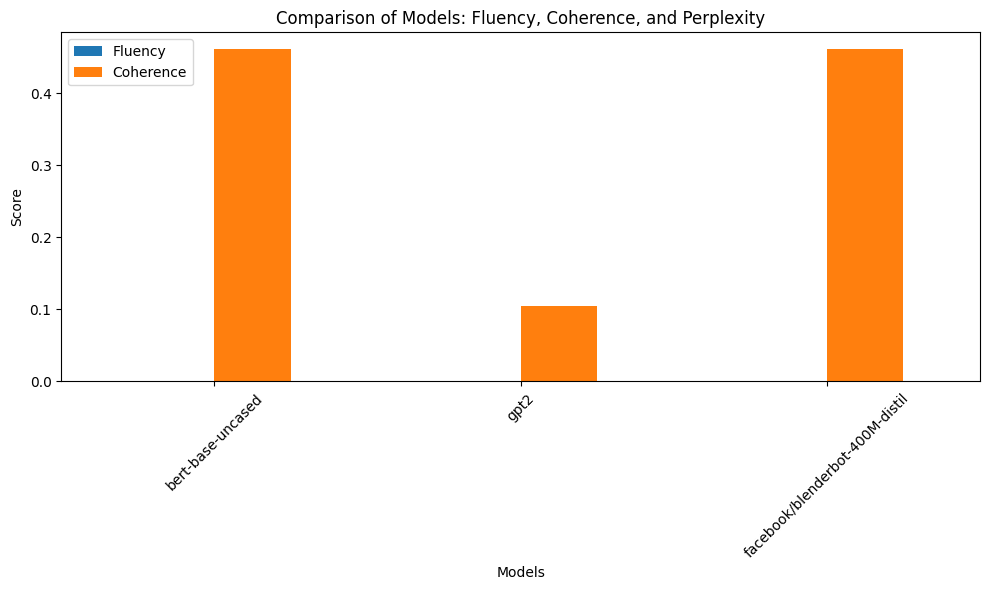

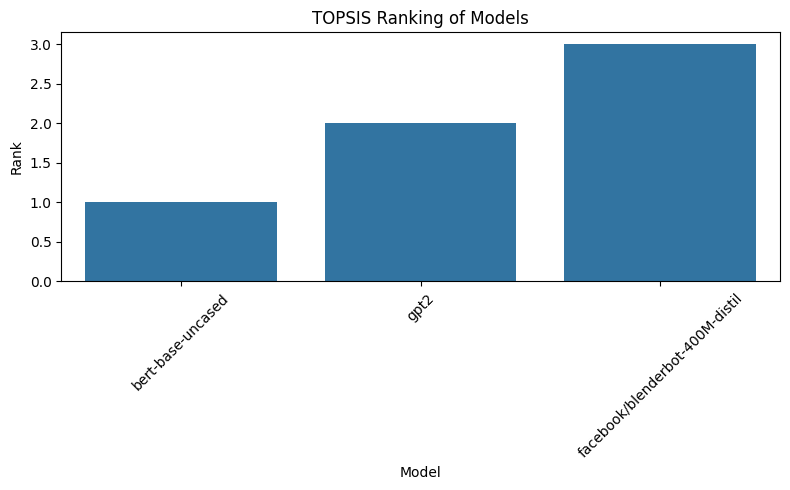

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

def topsis(decision_matrix, weights, criteria):


    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(decision_matrix)


    weighted_matrix = normalized_matrix * np.array(weights)


    ideal_best = np.max(weighted_matrix, axis=0)
    ideal_worst = np.min(weighted_matrix, axis=0)


    positive_separation = np.sqrt(np.sum((weighted_matrix - ideal_best)**2, axis=1))
    negative_separation = np.sqrt(np.sum((weighted_matrix - ideal_worst)**2, axis=1))


    closeness_coefficient = negative_separation / (positive_separation + negative_separation)


    rank = np.argsort(closeness_coefficient)[::-1] + 1

    results_df = pd.DataFrame({
        "Model": range(1, len(decision_matrix) + 1),
        "Closeness_Coefficient": closeness_coefficient,
        "Rank": rank
    })

    return results_df.sort_values("Rank")



def evaluate_model(model_name, text, reference_text):
    """Evaluates a model on given text and reference text."""

    try:

        if "gpt" in model_name.lower() or "dialogpt" in model_name.lower():
            generator = pipeline('text-generation', model=model_name, device=0)
            generated_text = generator(text, max_length=100)[0]['generated_text']
        else:
            generated_text = text


        bleu_score = sentence_bleu([reference_text.split()], generated_text.split())


        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        rouge_score = scorer.score(reference_text, generated_text)["rougeL"].fmeasure

        try:
            from transformers import AutoModelForCausalLM, AutoTokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
            from perplexity import calculate_perplexity
            perplexity = calculate_perplexity(model, tokenizer, [generated_text])
        except Exception as e:
            print(f"Perplexity calculation failed for {model_name}: {e}")
            perplexity = None

        return {
            "Fluency": bleu_score,
            "Coherence": rouge_score,
            "Perplexity": perplexity,
            "Generated_Text": generated_text
        }

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return None


models = ["bert-base-uncased", "gpt2", "facebook/blenderbot-400M-distil"]
input_text = "What is the weather like today?"
reference_text = "The weather is sunny and warm today."

results = []
for model_name in models:
    evaluation = evaluate_model(model_name, input_text, reference_text)
    if evaluation:
        results.append({"Model": model_name, **evaluation})

decision_matrix = []
for result in results:
    decision_matrix.append([result['Fluency'], result['Coherence'], result['Perplexity']])
decision_matrix = np.array(decision_matrix)

weights = [0.4, 0.3, 0.3]
criteria = [True, True, False]

topsis_results = topsis(decision_matrix, weights, criteria)

model_names = [result['Model'] for result in results]
topsis_results['Model'] = model_names

generated_texts = [result['Generated_Text'] for result in results]
topsis_results['Generated_Text'] = generated_texts

print(topsis_results)


fig, ax = plt.subplots(figsize=(10, 6))
scores = np.array([[result['Fluency'], result['Coherence'], result['Perplexity']] for result in results])
models = [result['Model'] for result in results]
labels = ['Fluency', 'Coherence', 'Perplexity']
scores_df = pd.DataFrame(scores, columns=labels, index=models)

scores_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Models: Fluency, Coherence, and Perplexity')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Model', y='Rank', data=topsis_results)
plt.title('TOPSIS Ranking of Models')
plt.ylabel('Rank')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
